## Import of the necessary library to perform analisis on the chemical data

In [1]:
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style("white")
import numpy as np

# Import & process the data

## File import

In [2]:
#Open hydrochemistry file

df  = pd.read_excel(r"test.xlsx")


print(df) # showing matrix
## A lot of < are inside the analisis which going to bring problem in data analisis as pandas no identify it as a number

#Extract column name
print(df.columns)

# Weight and balance of the major ions
ions_WEIGHT = {'Ca'  : 40.0780,
                   'Mg'  : 24.3050,
                   'K'   : 39.0983,
                   'Na'  : 22.9898,
                   'Cl'  : 35.4527,
                   'SO4' : 96.0636,
                   'HCO3': 61.0171}

ions_CHARGE = {'Ca'  : +2,
                   'Mg'  : +2,
                   'K'   : +1, 
                   'Na'  : +1,
                   'Cl'  : -1,
                   'SO4' : -2,
                   'HCO3': -1}

     Analysis    Area     TDS  SO4      Cl Alcalinity  HCO3    B     Ba  \
0           1   North  342900  415  197106        304   371  448  <0.20   
1           2   North  342900  418  197624        451   550  516   0.43   
2           3   North  339500  276  197000        401   490  494   0.29   
3           4   North  339700  343  196751        296   361  441  <0.20   
4           5   North  335300  681  192922        373   455  435  <0.20   
..        ...     ...     ...  ...     ...        ...   ...  ...    ...   
359       360   North  359700  263  200196        864  1054  822   0.34   
360       361   North  360300  261  199765        812   991  739   0.45   
361       362   North  336700  573  193878        374   456  414   0.29   
362       363  Center    4900   15    2876        <20   <10  <10  <0.10   
363       364   North     M.I   13    2878        M.I   M.I  <10  <0.10   

        Ca  ...   Li     Mg     Mn      Na     Sr   NO3      EC Density   pH  \
0    32675  ...  29

# Removing the detection limits of the analisis to have comparable sample

In [3]:
# Making a copy to keep in memory the initial dataFrame as comparison
df2 = df.copy()

for col in df2.columns:
    # processing only the columns containing "<"
    if df2[col].astype(str).str.contains('<').any():
        mask = df2[col].astype(str).str.contains('<', na=False)
        
        # We remove "<"
        cleaned = df2.loc[mask, col].astype(str).str.replace('<', '', regex=False)
        
        # Conversion to numeric and divide by 2 (norm) but it can be 10 or 5 as the users want
        df2.loc[mask, col] = pd.to_numeric(cleaned, errors='coerce') / 2

# Conversion of the df to numeric & describe stats data
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2.drop(columns=["Analysis"],inplace=True) # Remove the analysis from the value as is in the index

## Ionic balance calculation to evaluate the quality of the analisis

In [4]:
def ionic_balance(df):
    import numpy as np
    
    # Ions et propriétés
    ions_WEIGHT = {'Ca'  : 40.0780,
                   'Mg'  : 24.3050,
                   'K'   : 39.0983,
                   'Na'  : 22.9898,
                   'Cl'  : 35.4527,
                   'SO4' : 96.0636,
                   'HCO3': 61.0171}

    ions_CHARGE = {'Ca'  : +2,
                   'Mg'  : +2,
                   'K'   : +1, 
                   'Na'  : +1,
                   'Cl'  : -1,
                   'SO4' : -2,
                   'HCO3': -1}

    # Liste des ions classés en cations et anions
    cations = ['Ca', 'Mg', 'Na', 'K']
    anions = ['HCO3', 'Cl', 'SO4']
    
    # Initialisation des colonnes de meq/L
    meq_cat = np.zeros(len(df))
    meq_an = np.zeros(len(df))

    # Calcul des meq/L pour chaque cation
    for ion in cations:
        cols = [col for col in df.columns if ion in col]
        if cols:
            val = df[cols[0]].fillna(0)  # suppose une seule colonne par ion
            meq = val / ions_WEIGHT[ion] * abs(ions_CHARGE[ion])
            meq_cat += meq

    # Calcul des meq/L pour chaque anion
    for ion in anions:
        cols = [col for col in df.columns if ion in col]
        if cols:
            val = df[cols[0]].fillna(0)
            meq = val / ions_WEIGHT[ion] * abs(ions_CHARGE[ion])
            meq_an += meq

    # Calcul de l’équilibre ionique
    ionic_balance = abs(meq_cat - meq_an) / (meq_cat + meq_an)
    
    return ionic_balance


df2['Ionic_Balance'] = ionic_balance(df2)*100

df2

Area       TDS    SO4        Cl  Alcalinity    HCO3      B    Ba  \
0     NaN  342900.0  415.0  197106.0       304.0   371.0  448.0  0.10   
1     NaN  342900.0  418.0  197624.0       451.0   550.0  516.0  0.43   
2     NaN  339500.0  276.0  197000.0       401.0   490.0  494.0  0.29   
3     NaN  339700.0  343.0  196751.0       296.0   361.0  441.0  0.10   
4     NaN  335300.0  681.0  192922.0       373.0   455.0  435.0  0.10   
..    ...       ...    ...       ...         ...     ...    ...   ...   
359   NaN  359700.0  263.0  200196.0       864.0  1054.0  822.0  0.34   
360   NaN  360300.0  261.0  199765.0       812.0   991.0  739.0  0.45   
361   NaN  336700.0  573.0  193878.0       374.0   456.0  414.0  0.29   
362   NaN    4900.0   15.0    2876.0        10.0     5.0    5.0  0.05   
363   NaN       NaN   13.0    2878.0         NaN     NaN    5.0  0.05   

          Ca   Fe  ...       Mg     Mn        Na     Sr    NO3      EC  \
0    32675.0  3.0  ...   5334.0   5.63   85153.0  558.5   6.50  230.06   
1    33945.0  3.0  ...   6070.0   1.59   81172.0  572.2   8.20  228.17   
2    31212.0  3.0  ...   5727.0   3.40   82482.0  565.3   7.50  229.57   
3    31846.0  3.0  ...   5218.0   5.79   83553.0  552.8   6.60  228.65   
4    11173.0  3.0  ...   4656.0   0.10  103536.0  258.8  14.90  228.64   
..       ...  ...  ...      ...    ...       ...    ...    ...     ...   
359  34599.0  3.0  ...  11622.0   5.97   71808.0  780.3   4.60  213.74   
360  34555.0  3.0  ...  10549.0  15.62   72136.0  729.7   4.50  214.56   
361  10945.0  3.0  ...   4854.0   0.10   97724.0  258.8  15.30  234.45   
362     10.0  1.5  ...      5.0   0.05    1894.0    2.5   0.15    8.84   
363     10.0  1.5  ...      5.0   0.05    1886.0    2.5    NaN    8.87   

     Density   pH  Nitritos  Ionic_Balance  
0      1.220  6.1      0.03       2.409586  
1      1.222  6.2      0.01       2.059865  
2      1.220  6.2      0.01       1.320490  
3      1.219  6.1      0.03       1.478875  
4      1.212  6.8      0.01       1.328085  
..       ...  ...       ...            ...  
359    1.223  6.1      0.03       2.073815  
360    1.223  6.1      0.04       1.613120  
361    1.212  6.7      0.01       1.150723  
362    1.003  6.7      0.01       1.232338  
363    1.003  6.8      0.01       1.064897  

[364 rows x 22 columns]

count    364.000000
mean       7.381918
std       19.908941
min        0.002707
25%        0.688921
50%        1.182704
75%        1.987283
max      100.000000
Name: Ionic_Balance, dtype: float64

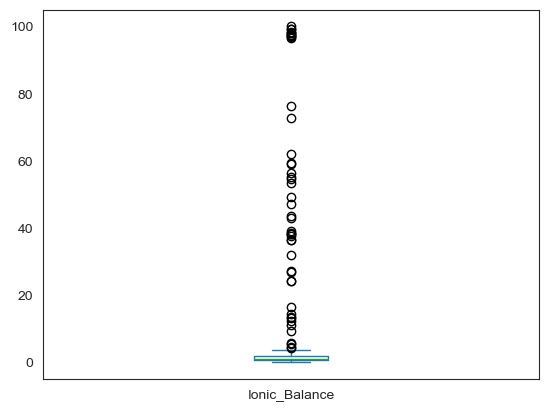

In [7]:
df2['Ionic_Balance'].plot.box()
df2['Ionic_Balance'].describe() # Stats of the ionic balance

In [8]:
## Showing the data with ionic balance >5%, can be change depending of the TDS of Water
df_non_representative = df2[df2['Ionic_Balance']>5]
df_non_representative

Area     TDS    SO4      Cl  Alcalinity      HCO3       B      Ba  \
35    NaN   468.0  141.0    25.0       146.0    0.0105  0.0300  0.0525   
36    NaN   514.0  221.0    79.0        74.0    0.0105  0.0300  0.0525   
37    NaN  1690.0  360.0   450.0       309.0    0.0105  0.0300  0.1450   
38    NaN  5442.0  433.0  2267.0       805.0    0.0105  0.0300  0.4310   
39    NaN   232.0   78.0    16.0        55.0    0.0105  0.0300  0.0525   
40    NaN   578.0  220.0    26.0       183.0    0.0105  0.2600  0.0525   
41    NaN   152.0   45.0     5.0        46.0    0.0105  0.0300  0.0525   
42    NaN   276.0   79.0    13.0        62.0    0.0105  0.0300  0.0525   
43    NaN     NaN  100.0    60.0       339.0    0.0105  0.0300  0.0525   
44    NaN     NaN  104.0    58.0         NaN    0.0105  0.0300  0.0525   
65    NaN   114.0   35.0     5.0        36.0   43.0000  0.0105  0.0300   
66    NaN   200.0   75.0    18.0        47.0   57.0000  0.0105  0.0300   
67    NaN   376.0   82.0    23.0       149.0  168.0000  0.0105  0.0300   
68    NaN   556.0   73.0   183.0        91.0  111.0000  0.0105  0.0300   
69    NaN   626.0   67.0    61.0       333.0  365.0000  0.0105  0.0300   
71    NaN  1830.0  156.0   713.0        10.0   18.0000  0.0105  0.0300   
72    NaN   522.0  191.0    43.0        83.0  101.0000  0.0105  0.0300   
137   NaN   624.0    NaN   188.0        88.0  108.0000  2.0000  0.0050   
166   NaN   572.0    NaN     NaN         NaN       NaN  2.0000  0.0050   
208   NaN   212.0   82.0    13.0        47.0   57.0000  0.0105  0.0300   
209   NaN  5016.0  900.0  1692.0       657.0  802.0000  0.0105  0.0300   
210   NaN  1400.0  267.0   412.0       199.0  243.0000  0.0105  0.0300   
211   NaN   408.0  151.0    35.0        74.0   90.0000  0.0105  0.0300   
212   NaN  1200.0  371.0   328.0        79.0   96.0000  0.0105  0.0300   
213   NaN  1600.0  200.0   717.0        10.0   16.0000  0.0105  0.0300   
214   NaN  5102.0  412.0  2084.0       672.0  820.0000  0.0105  0.0300   
215   NaN   536.0  156.0    24.0       178.0  217.0000  0.0105  2.2400   
216   NaN   140.0   29.0    10.0        43.0   52.0000  0.0105  0.0300   
217   NaN   114.0   22.0     5.0        37.0   45.0000  0.0105  0.0300   
218   NaN   726.0   47.0    67.0       376.0  459.0000  0.0105  0.0300   
288   NaN   462.0  109.0    31.0       132.0  161.0000  0.0105  0.0300   
289   NaN   796.0   59.0    79.0       440.0  439.0000  0.0105  0.0300   
290   NaN   586.0   63.0   177.0        94.0  115.0000  0.0105  0.0300   
291   NaN   132.0   21.0    13.0        52.0   63.0000  0.0105  0.0300   
292   NaN  1714.0  163.0   719.0        30.0   37.0000  0.0105  0.0300   
293   NaN   440.0  133.0    41.0        74.0   90.0000  0.0105  0.0300   
294   NaN  1314.0  338.0   372.0        92.0  112.0000  0.0105  0.0300   
295   NaN   138.0   12.0    21.0        50.0   61.0000  0.0105  0.0300   
296   NaN   142.0    NaN    21.0        51.0   62.0000  0.0105  0.0300   
297   NaN   902.0  446.0    79.0        24.0   29.0000  0.0105  0.0300   
298   NaN   890.0  455.0    77.0        22.0   27.0000  0.0105  0.0300   
299   NaN  1862.0  304.0   576.0       274.0  334.0000  0.0105  0.0300   
300   NaN   548.0   88.0    98.0       136.0  166.0000  0.0105  0.0300   
301   NaN   280.0   86.0    23.0        35.0   43.0000  0.0105  0.0300   
302   NaN   278.0   86.0    22.0        38.0   46.0000  0.0105  0.0300   

          Ca       Fe  ...        Mg      Mn       Na      Sr     NO3     EC  \
35    0.7210   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0060  0.015   
36    0.5840   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0060  0.015   
37    4.9020   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0190  0.015   
38   19.5910   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0060  0.015   
39    0.3080   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0060  0.015   
40    0.4430   0.0015  ...    0.0015  0.0030    0.006  0.0045  0.0690  0.015   
41    0.2170   0.0015  ...    0.0015  0.

In [50]:
# At this stage you can save the dataframe as an excel file to vizualise it 
df2.to_excel('your_path')

ValueError: Unable to coerce to Series, length must be 4: given 7

## Exploring the data : Stats & Relation between variable

In [9]:
# Conversion of the df to numeric & describe stats data
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2['Area'] = df['Area'] # Remove the analysis from the value as is in the index
df2

Area       TDS    SO4        Cl  Alcalinity    HCO3      B    Ba  \
0     North  342900.0  415.0  197106.0       304.0   371.0  448.0  0.10   
1     North  342900.0  418.0  197624.0       451.0   550.0  516.0  0.43   
2     North  339500.0  276.0  197000.0       401.0   490.0  494.0  0.29   
3     North  339700.0  343.0  196751.0       296.0   361.0  441.0  0.10   
4     North  335300.0  681.0  192922.0       373.0   455.0  435.0  0.10   
..      ...       ...    ...       ...         ...     ...    ...   ...   
359   North  359700.0  263.0  200196.0       864.0  1054.0  822.0  0.34   
360   North  360300.0  261.0  199765.0       812.0   991.0  739.0  0.45   
361   North  336700.0  573.0  193878.0       374.0   456.0  414.0  0.29   
362  Center    4900.0   15.0    2876.0        10.0     5.0    5.0  0.05   
363   North       NaN   13.0    2878.0         NaN     NaN    5.0  0.05   

          Ca   Fe  ...       Mg     Mn        Na     Sr    NO3      EC  \
0    32675.0  3.0  ...   5334.0   5.63   85153.0  558.5   6.50  230.06   
1    33945.0  3.0  ...   6070.0   1.59   81172.0  572.2   8.20  228.17   
2    31212.0  3.0  ...   5727.0   3.40   82482.0  565.3   7.50  229.57   
3    31846.0  3.0  ...   5218.0   5.79   83553.0  552.8   6.60  228.65   
4    11173.0  3.0  ...   4656.0   0.10  103536.0  258.8  14.90  228.64   
..       ...  ...  ...      ...    ...       ...    ...    ...     ...   
359  34599.0  3.0  ...  11622.0   5.97   71808.0  780.3   4.60  213.74   
360  34555.0  3.0  ...  10549.0  15.62   72136.0  729.7   4.50  214.56   
361  10945.0  3.0  ...   4854.0   0.10   97724.0  258.8  15.30  234.45   
362     10.0  1.5  ...      5.0   0.05    1894.0    2.5   0.15    8.84   
363     10.0  1.5  ...      5.0   0.05    1886.0    2.5    NaN    8.87   

     Density   pH  Nitritos  Ionic_Balance  
0      1.220  6.1      0.03       2.409586  
1      1.222  6.2      0.01       2.059865  
2      1.220  6.2      0.01       1.320490  
3      1.219  6.1      0.03       1.478875  
4      1.212  6.8      0.01       1.328085  
..       ...  ...       ...            ...  
359    1.223  6.1      0.03       2.073815  
360    1.223  6.1      0.04       1.613120  
361    1.212  6.7      0.01       1.150723  
362    1.003  6.7      0.01       1.232338  
363    1.003  6.8      0.01       1.064897  

[364 rows x 22 columns]

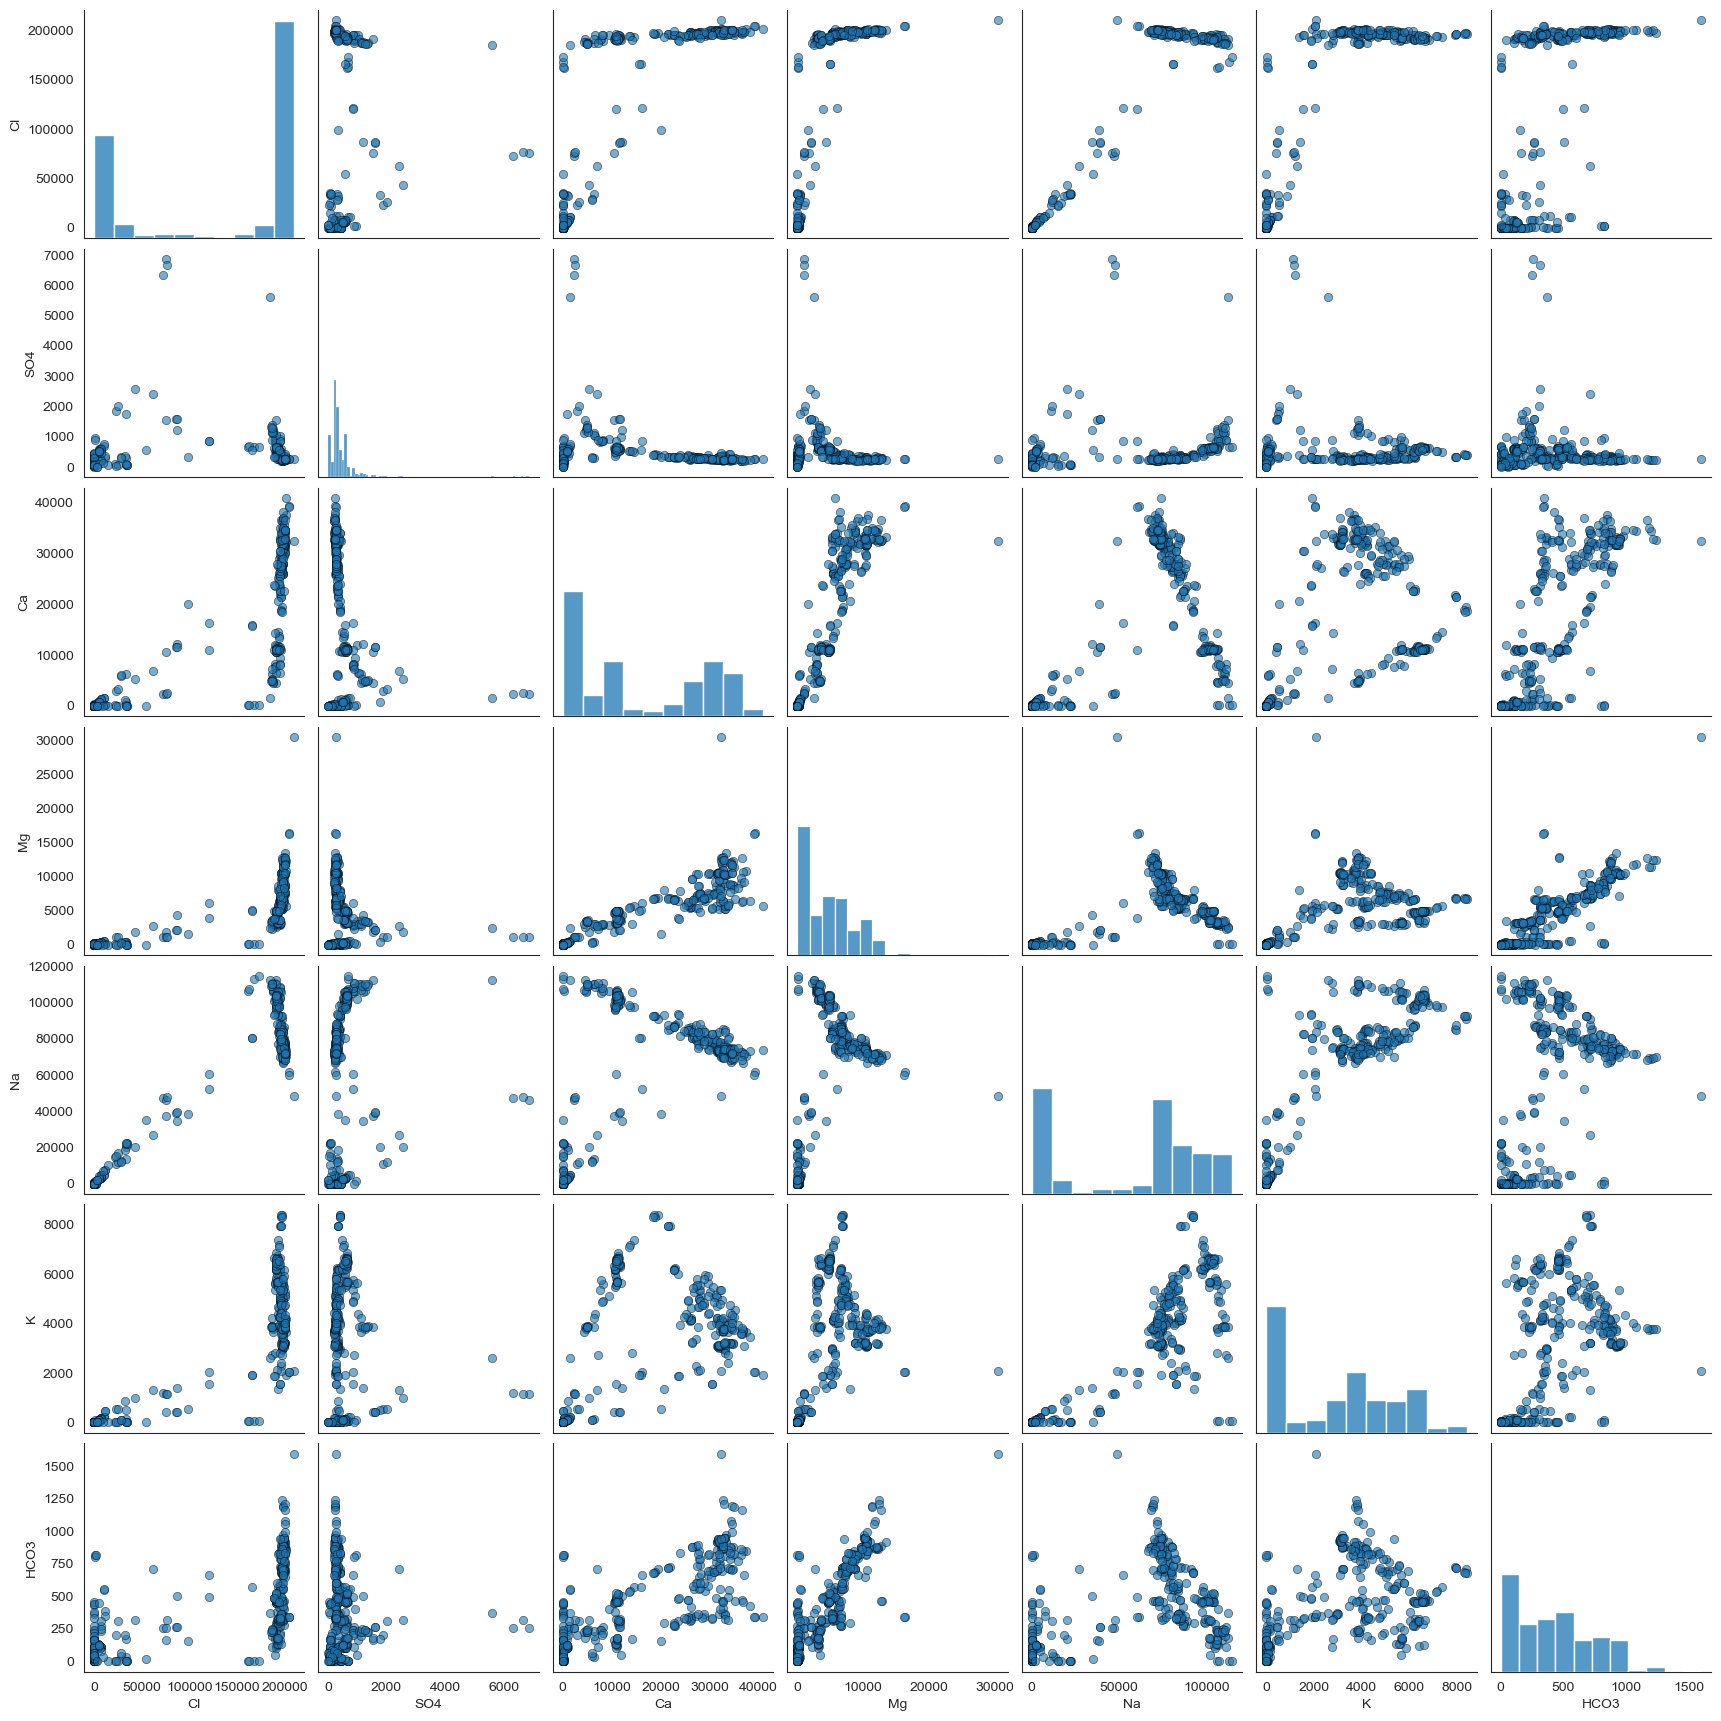

In [10]:
# Seaborn as very simple function to plot the correlation between the different variable here we take only the majors ions to see
key_ion = ['Cl','SO4','Ca','Mg','Na','K','HCO3']
subset = df2[key_ion]
sns.pairplot(subset, vars = key_ion, diag_kind='hist', plot_kws={'alpha':0.6, 'edgecolor':'k'})

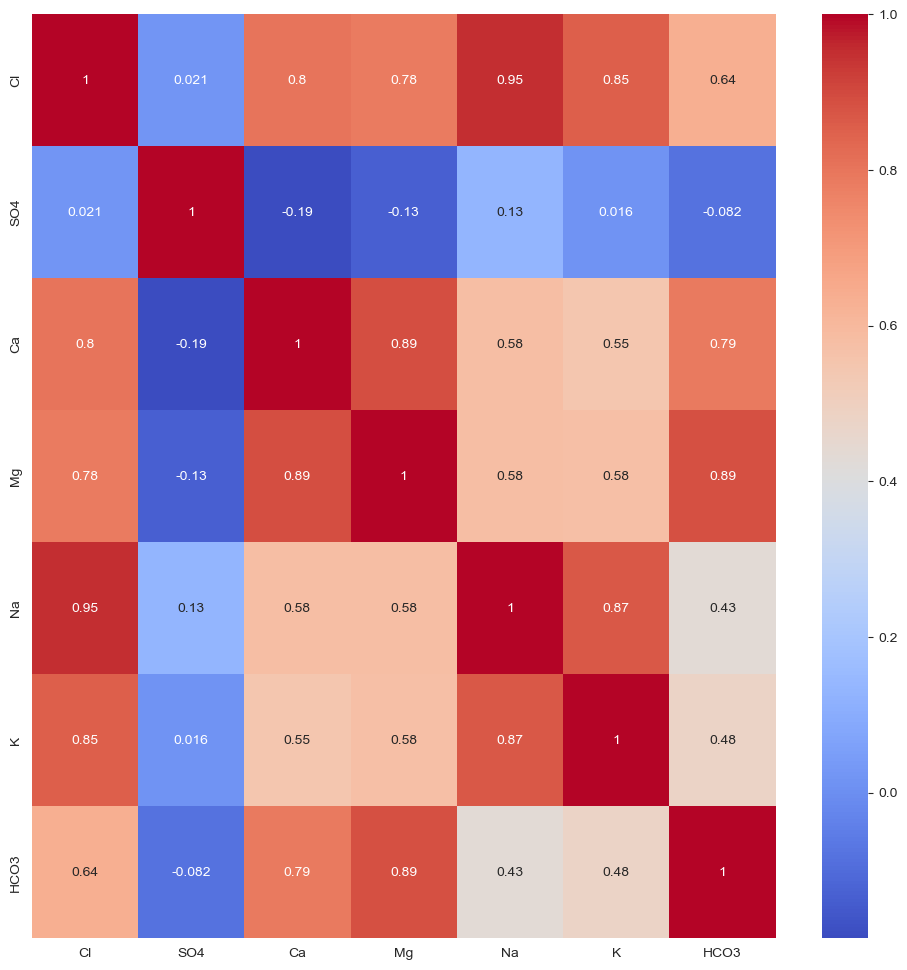

In [16]:
# Other representation to see the correlation between variable is the correlation matrix
corr = subset.corr(numeric_only = True)
# Plotting the results of the correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True,cmap="coolwarm")
plt.show()

## Different plotting

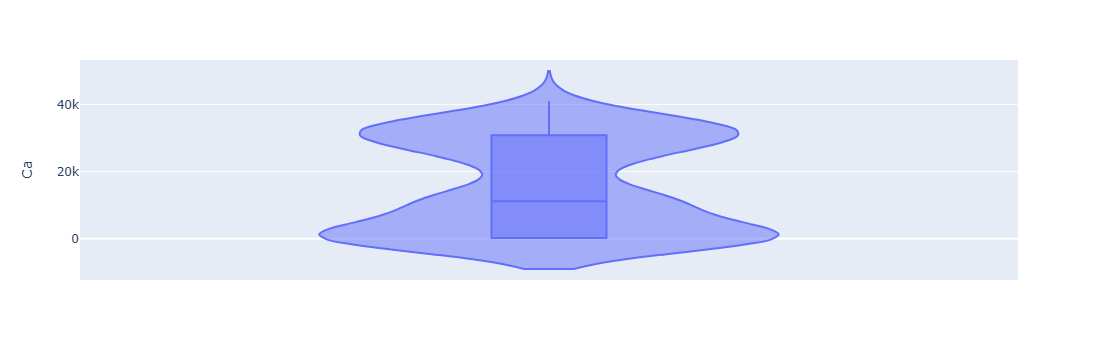

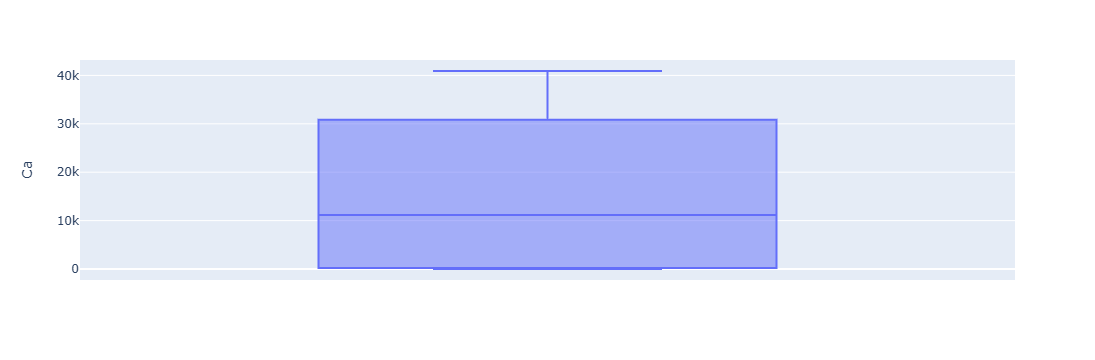

In [8]:
# Several plotting library are available matplotlib or seaborn or plotly. The most interactive is plotly and will be use there

import plotly.express as px

# Violin plot : easy representation and more representative than boxplot
# In our case 2 repartition seen in the violin but absent in "Traditional box plot"
# Please refer to plotly documentation to see all the functionality for violin
fig = px.violin(df2, y="Ca",box = True)
fig2 = px.box(df2, y="Ca")
fig.show()
fig2.show()

## PCA analysis to see groups of aquifer

In [18]:
df2 = df2.dropna()
numerical = df2.select_dtypes(include='float64').columns

#Comme aucune des variables à la même unité --> Centrage et normage des valeurs
sc = StandardScaler()
Z = sc.fit_transform(df2[numerical])


#Application de la décomposition en variables 
pca = PCA()
coord = pca.fit_transform(Z)


#Tableau récapitulatif des dimensions généré par l'ACP
ig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
print (ig)

   Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1           10.973348                  52.0                   52.0
1       Dim2            2.366223                  11.0                   63.0
2       Dim3            1.934849                   9.0                   73.0
3       Dim4            1.332220                   6.0                   79.0
4       Dim5            1.097026                   5.0                   84.0
5       Dim6            0.915610                   4.0                   88.0
6       Dim7            0.632599                   3.0                   91.0
7       Dim8            0.571802                   3.0                   94.0
8       Dim9            0.394647                   2.0                   96.0
9      Dim10            0.313328                   1.0                   97.0
10     Dim11            0.223100                   1.0                   99.0
11     Dim12            0.144902                   1.0          

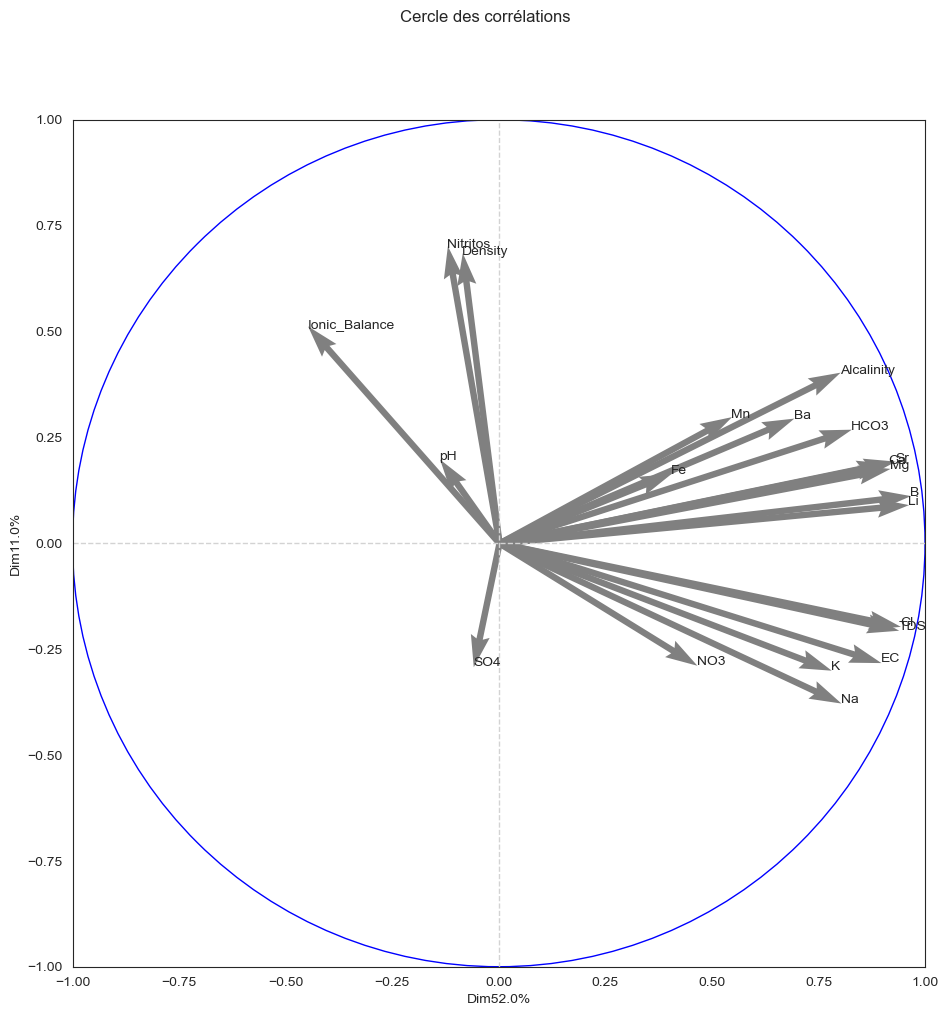

In [20]:
#Représentation en cercle
n = df2[numerical].shape[0] # nb individus
p = df2[numerical].shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': df2[numerical].columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (11,11))
fig.suptitle("Cercle des corrélations")
plt.xlabel("Dim"+ str(np.round(pca.explained_variance_ratio_[0] * 100))+"%")
plt.ylabel("Dim"+ str(np.round(pca.explained_variance_ratio_[1] * 100))+"%")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)

# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
    
#Affichage flèche
for i in range (p):
    plt.quiver(coordvar["COR_1"][i],coordvar["COR_2"][i],scale = 2,color="grey")


# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

In [22]:
#Qualité de représentations des data
cos2var = corvar**2

Representativite = pd.DataFrame({'id':df2[numerical].columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]})
print(Representativite)


#Contribution aux axes
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]

    
#on n'affiche que pour les deux premiers axes
Contribution = pd.DataFrame({'id':df2[numerical].columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]})
print(Contribution)

               id    COS2_1    COS2_2
0             TDS  0.879324  0.041886
1             SO4  0.003647  0.084282
2              Cl  0.886735  0.038257
3      Alcalinity  0.640361  0.160627
4            HCO3  0.683283  0.071294
5               B  0.931989  0.012370
6              Ba  0.478615  0.085860
7              Ca  0.834327  0.035077
8              Fe  0.163438  0.026769
9               K  0.607614  0.089068
10             Li  0.923227  0.008110
11             Mg  0.841645  0.030625
12             Mn  0.297783  0.087925
13             Na  0.643631  0.140995
14             Sr  0.864623  0.036919
15            NO3  0.215506  0.082254
16             EC  0.802851  0.078712
17        Density  0.007417  0.463817
18             pH  0.019423  0.038740
19       Nitritos  0.014668  0.486394
20  Ionic_Balance  0.201710  0.259442
               id     CTR_1     CTR_2
0             TDS  0.080364  0.017753
1             SO4  0.000333  0.035722
2              Cl  0.081041  0.016215
3      Alcal

## More intuitive representation Coordinates in the dimension plan to see if there is any trend

In [23]:
# Transformation en DataFrame pandas
#Calcul des coordonnées des données compilé dans l'espace vectorielle
donnees_compile_pca = pca.transform(coord)

donnees_compile_pca_df = pd.DataFrame({
    "Dim1" : donnees_compile_pca[:,0], 
    "Dim2" : donnees_compile_pca[:,1],
    "Dim3" : df2['Area']
})

# Résultat (premières lignes)
donnees_compile_pca_df.head()

Dim1      Dim2   Dim3
0  0.015343 -0.448164  North
1  0.316633 -0.673913  North
2  0.157109 -0.647363  North
3 -0.053758 -0.437703  North
4  0.963573 -0.150031  North

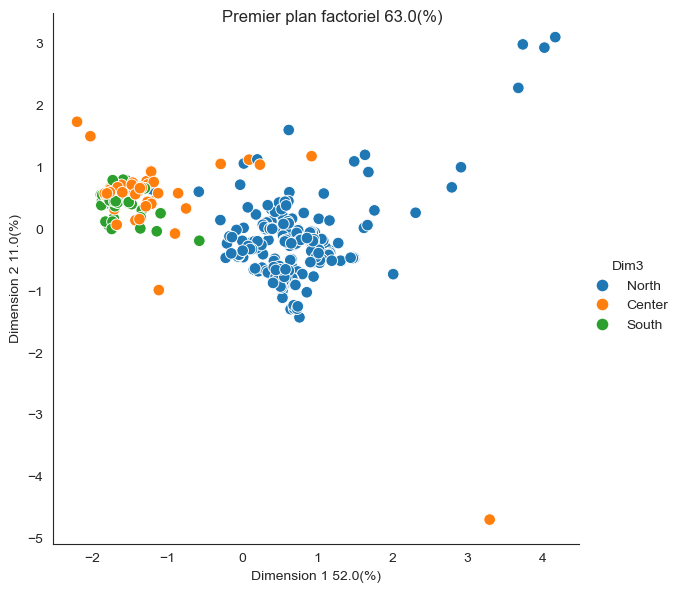

In [28]:
sns.relplot(data=donnees_compile_pca_df, x="Dim1",y="Dim2",hue = "Dim3",height=6,s=70)
# Placement des étiquettes de station
plt.xlabel("Dimension 1"+" " +str(ig["% variance expliquée"][0])+"(%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2"+" " +str(ig["% variance expliquée"][1])+"(%)") # idem pour axe Y
plt.suptitle("Premier plan factoriel"+ " "+ str(ig["% variance expliquée"][0]+ig["% variance expliquée"][1])+"(%)") # titre général
plt.show()

# Hydrochemical plotting

In [23]:
# To perform the hydrochemical plotting, we will use the wqcharty library
import wqchartpy
from wqchartpy import stiff, gibbs, triangle_piper

# Defining labelling, marker and color for each sample
color_map = {"North": "red", "Center": "green", "South": "yellow"}
df2['Size'] = 30
df2['Alpha'] = 0.6
df2['Marker'] = 'o'
df2['Color'] =df2['Area'].map(color_map).fillna('gray')
df2['Label'] = df2['Area']

Area       TDS    SO4        Cl  Alcalinity    HCO3      B    Ba  \
0     NaN  342900.0  415.0  197106.0       304.0   371.0  448.0  0.10   
1     NaN  342900.0  418.0  197624.0       451.0   550.0  516.0  0.43   
2     NaN  339500.0  276.0  197000.0       401.0   490.0  494.0  0.29   
3     NaN  339700.0  343.0  196751.0       296.0   361.0  441.0  0.10   
4     NaN  335300.0  681.0  192922.0       373.0   455.0  435.0  0.10   
..    ...       ...    ...       ...         ...     ...    ...   ...   
359   NaN  359700.0  263.0  200196.0       864.0  1054.0  822.0  0.34   
360   NaN  360300.0  261.0  199765.0       812.0   991.0  739.0  0.45   
361   NaN  336700.0  573.0  193878.0       374.0   456.0  414.0  0.29   
362   NaN    4900.0   15.0    2876.0        10.0     5.0    5.0  0.05   
363   NaN       NaN   13.0    2878.0         NaN     NaN    5.0  0.05   

          Ca   Fe  ...      EC  Density   pH  Nitritos  Ionic_Balance  Size  \
0    32675.0  3.0  ...  230.06    1.220  6.1      0.03       2.409586    30   
1    33945.0  3.0  ...  228.17    1.222  6.2      0.01       2.059865    30   
2    31212.0  3.0  ...  229.57    1.220  6.2      0.01       1.320490    30   
3    31846.0  3.0  ...  228.65    1.219  6.1      0.03       1.478875    30   
4    11173.0  3.0  ...  228.64    1.212  6.8      0.01       1.328085    30   
..       ...  ...  ...     ...      ...  ...       ...            ...   ...   
359  34599.0  3.0  ...  213.74    1.223  6.1      0.03       2.073815    30   
360  34555.0  3.0  ...  214.56    1.223  6.1      0.04       1.613120    30   
361  10945.0  3.0  ...  234.45    1.212  6.7      0.01       1.150723    30   
362     10.0  1.5  ...    8.84    1.003  6.7      0.01       1.232338    30   
363     10.0  1.5  ...    8.87    1.003  6.8      0.01       1.064897    30   

     Alpha  Marker  Color  Label  
0      0.6       o   gray    NaN  
1      0.6       o   gray    NaN  
2      0.6       o   gray    NaN  
3      0.6       o   gray    NaN  
4      0.6       o   gray    NaN  
..     ...     ...    ...    ...  
359    0.6       o   gray    NaN  
360    0.6       o   gray    NaN  
361    0.6       o   gray    NaN  
362    0.6       o   gray    NaN  
363    0.6       o   gray    NaN  

[364 rows x 27 columns]

## Gibbs Diagram

In [25]:
# First we will define sub dataframe for each plot, we will had color and marker into the dataframe for plotting
df_gibbs = df2[['Area','Label','Color','Marker','Size','Alpha','Na','Ca','Cl','HCO3','TDS']]

Area   Label  Color Marker  Size  Alpha        Na       Ca        Cl  \
0     North   North    red      o    30    0.6   85153.0  32675.0  197106.0   
1     North   North    red      o    30    0.6   81172.0  33945.0  197624.0   
2     North   North    red      o    30    0.6   82482.0  31212.0  197000.0   
3     North   North    red      o    30    0.6   83553.0  31846.0  196751.0   
4     North   North    red      o    30    0.6  103536.0  11173.0  192922.0   
..      ...     ...    ...    ...   ...    ...       ...      ...       ...   
359   North   North    red      o    30    0.6   71808.0  34599.0  200196.0   
360   North   North    red      o    30    0.6   72136.0  34555.0  199765.0   
361   North   North    red      o    30    0.6   97724.0  10945.0  193878.0   
362  Center  Center  green      o    30    0.6    1894.0     10.0    2876.0   
363   North   North    red      o    30    0.6    1886.0     10.0    2878.0   

       HCO3       TDS  
0     371.0  342900.0  
1     550.0  342900.0  
2     490.0  339500.0  
3     361.0  339700.0  
4     455.0  335300.0  
..      ...       ...  
359  1054.0  359700.0  
360   991.0  360300.0  
361   456.0  336700.0  
362     5.0    4900.0  
363     NaN       NaN  

[364 rows x 11 columns]

Gibbs plot created. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique 



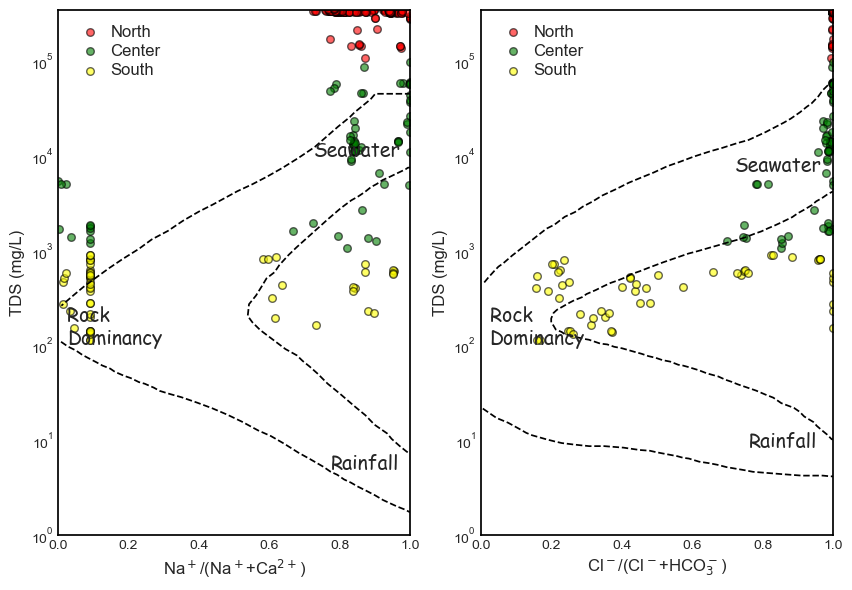

In [30]:
# The gibbs plot is created and directly save in your directory
import matplotlib.pyplot as plt

gibbs.plot(df_gibbs, unit='mg/L', figname='Gibbs diagram', figformat='jpg')

# As we have very High TDS sample we need to get the figure and modify the y_lim as in the gibbs function it's set to 45 000 mg/L
fig = plt.gcf()             # Récupère la figure actuelle
axes = fig.get_axes()       # Liste de tous les axes (souvent 2)

for ax in axes:
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(max(1, ymin), 350000)

fig.savefig("Gibbs_modifié.jpg", dpi=300)

## Piper Diagram

Trilinear Piper plot created. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique 



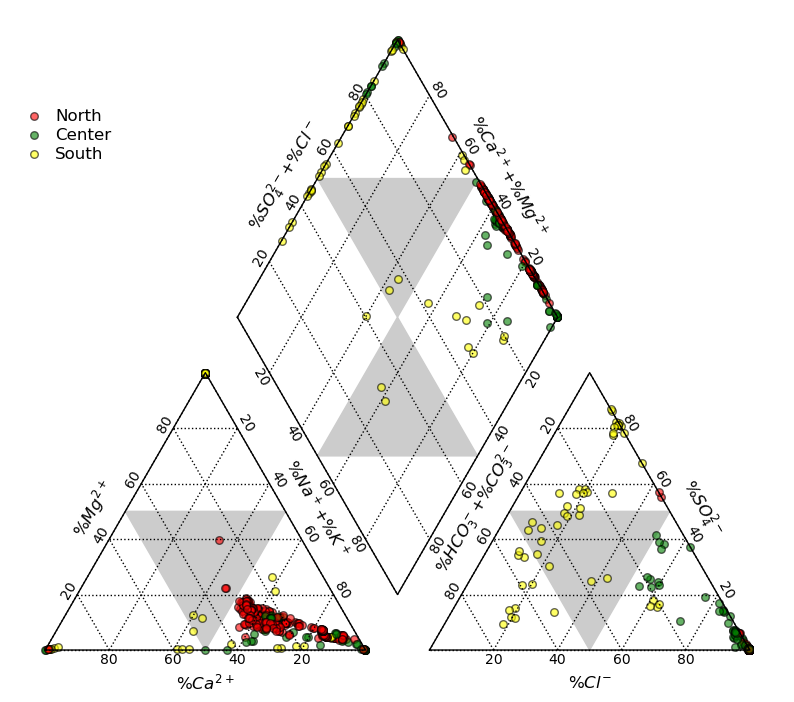

In [31]:
# We define some parameter in advance
df2['CO3'] =0 # we have only HCO3 in our sample due to PH conditions
triangle_piper.plot(df2, unit='mg/L', figname='triangle Piper diagram', figformat='jpg')

## Stiff Diagram

In [56]:
# As we see in our exploration of the data we have 3 different zones with 3 very different TDS values
# So to facilitate the vizualisation of each group we will separe it in 3 sub fresh, brackish and brine water and modifiy the initial code of wqchartpy
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from pylab import *
import os

def get_water_type_and_color(CE):
    if CE < 10:
        return 'Fresh water', 'lightblue'
    elif 10 <= CE < 110:
        return 'Brackish', 'green'
    else:
        return 'Brine', 'red'
    
def get_xlim_by_tds(CE):
    """Définit l'échelle X en fonction du TDS."""
    if CE < 10:
        return 50  # Fresh
    elif 20 <= CE < 110:
        return 1000  # Brackish
    else:
        return 5000  # Brine

def plot(df, 
         unit='mg/L', 
         figname='Stiff diagram', 
         figformat='jpg'):
    """Plot the Stiff diagram.
    
    Parameters
    ----------
    df : class:`pandas.DataFrame`
        Geochemical data to draw Stiff diagram.
    unit : class:`string`
        The unit used in df. Currently only mg/L is supported. 
    figname : class:`string`
        A path or file name when saving the figure.
    figformat : class:`string`
        The file format, e.g. 'png', 'pdf', 'svg'
        
        
     References
    ----------
    .. [1] Stiff, H.A. 1951.
           The Interpretation of Chemical Water Analysis by Means of Patterns
           Journal of Petroleum Technology 3(10): 15-3
           https://doi.org/10.2118/951376-G
    """
    # Basic data check 
    # -------------------------------------------------------------------------
    # Determine if the required geochemical parameters are defined. 
    if not {'Sample', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4'}.issubset(df.columns):
        raise RuntimeError("""
        Stiff diagram uses geochemical parameters Ca, Mg, Na, K, HCO3, Cl, and SO4.
        Also, Sample is requied to save the Stiff diagram to disk for each sample.
        Confirm that these parameters are provided in the input file.""")
        
    # Determine if the provided unit is allowed
    ALLOWED_UNITS = ['mg/L', 'meq/L']
    if unit not in ALLOWED_UNITS:
        raise RuntimeError("""
        Currently only mg/L and meq/L are supported.
        Convert the unit manually if needed.""")
        
    # Convert unit if needed
    if unit == 'mg/L':
        gmol = np.array([ions_WEIGHT['Ca'], 
                         ions_WEIGHT['Mg'], 
                         ions_WEIGHT['Na'], 
                         ions_WEIGHT['K'], 
                         ions_WEIGHT['HCO3'],
                         ions_WEIGHT['Cl'], 
                         ions_WEIGHT['SO4']])
    
        eqmol = np.array([ions_CHARGE['Ca'], 
                          ions_CHARGE['Mg'], 
                          ions_CHARGE['Na'], 
                          ions_CHARGE['K'], 
                          ions_CHARGE['HCO3'],  
                          ions_CHARGE['Cl'], 
                          ions_CHARGE['SO4']])
    
        tmpdf = df[['Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']]
        dat = tmpdf.values
        
        meqL = (dat / abs(gmol)) * abs(eqmol)
        
    elif unit == 'meq/L':
        meqL = df[['Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']].values
    
    else:
        raise RuntimeError("""
        Currently only mg/L and meq/L are supported.
        Convert the unit if needed.""")
   
    cat_max = np.max(np.array(((meqL[:, 2] + meqL[:, 3]), meqL[:, 0], meqL[:, 1])))
    an_max = np.max(meqL[:, 4:])
    
    # Plot the Stiff diagrams for each sample
    # -------------------------------------------------------------------------
    Labels = []
    for i in range(len(df)):
        TDS_value = df.at[i, 'CE']
        water_type, color = get_water_type_and_color(TDS_value)
        xlim_value = get_xlim_by_tds(TDS_value)  # Définition de l'échelle X selon le TDS

        if (df.at[i, 'Label'] in Labels or df.at[i, 'Label'] == ''):
            TmpLabel = ''
        else:
            TmpLabel = df.at[i, 'Label']
            Labels.append(TmpLabel)
    
        try:
            x = [-(meqL[i, 2] + meqL[i, 3]), -meqL[i, 0], -meqL[i, 1], 
                 meqL[i, 6], meqL[i, 4], meqL[i, 5], -(meqL[i, 2] + meqL[i, 3])]
            y = [3, 2, 1, 1, 2, 3, 3]
            
            plt.figure(figsize=(3, 3))
            plt.gca().set_facecolor('none')  # Supprime le fond blanc derrière le graphe
            plt.gcf().set_facecolor('none')  # Supprime le fond blanc global

            plt.fill(x, y, facecolor=color, edgecolor='k', linewidth=1.25)
            
            plt.plot([0, 0], [1, 3], 'k-.', linewidth=1.25)
            plt.plot([-0.5, 0.5], [2, 2], 'k-')
  
            plt.xlim([-xlim_value, xlim_value]) 
            plt.text(-xlim_value, 2.9, 'Na$^+$' + '+' + 'K$^+$', fontsize=12, ha= 'right')
            plt.text(-xlim_value, 1.9, 'Ca$^{2+}$', fontsize=12, ha= 'right')
            plt.text(-xlim_value, 1.0, 'Mg$^{2+}$', fontsize=12, ha= 'right')
            
            plt.text(xlim_value, 2.9,'Cl$^-$',fontsize=12, ha= 'left')
            plt.text(xlim_value, 1.9,'HCO'+'$_{3}^-$',fontsize=12,ha= 'left')
            plt.text(xlim_value, 1.0,'SO'+'$_{4}^{2-}$',fontsize=12,ha= 'left')
            
            ax = plt.gca()
            ax.spines['left'].set_color('None')
            ax.spines['right'].set_color('None')
            ax.spines['top'].set_color('None')
            minorticks_off()
            tick_params(which='major', direction='out', length=4, width=1.25)
            tick_params(which='minor', direction='in', length=2, width=1.25)
            ax.spines['bottom'].set_linewidth(1.25)
            ax.spines['bottom'].set_color('k')
            #ylim(0.8, 3.2)
            setp(gca(), yticks=[], yticklabels=[])
            #plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
            ticks = np.array([-xlim_value, -xlim_value/2, 0, xlim_value/2, xlim_value])
            tickla = [f'{tick:1.0f}' for tick in abs(ticks)]
            ax.xaxis.set_ticks(ticks)
            ax.xaxis.set_ticklabels(tickla)
            
            labels = ax.get_xticklabels()
            [label.set_fontsize(10) for label in labels]
            ax.set_xlabel('Stiff diagram (meq/L)', fontsize=12, weight='normal')
                
            ax.set_title(df.at[i, 'Sample'], fontsize=14, weight='normal')

        except(ValueError):
                pass
    
        # Display the info
        cwd = os.getcwd()
        print("Stiff plot created for %s. Saving it to %s\n" %(str(df.at[i, 'Sample']), cwd))
    
        # Save the figure
        plt.savefig(figname + '_' + str(df.at[i, 'Sample']) + '.' + figformat, format=figformat, 
                    bbox_inches='tight', dpi=300,transparent = True)
        
    return 

In [58]:
# we will just take a subset of our data to not save 300 figure
a = df2[df2['Area'] =='North']
b = df2[df2['Area'] =='Center']
c = df2[df2['Area'] =='South']

df_stiff = pd.concat([a[0:2],b[0:2],c[0:2]], axis = 0)

df_stiff['Sample'] = df_stiff.index
df_stiff.reset_index(inplace=True, drop=False)
# To be in line with the stiff plot funcion we rename the Electrical conductivity columns

df_stiff = df_stiff.rename(columns={'EC': 'CE'})
print(df_stiff)

   index    Area       TDS    SO4        Cl  Alcalinity      HCO3       B  \
0      0   North  342900.0  415.0  197106.0       304.0  371.0000  448.00   
1      1   North  342900.0  418.0  197624.0       451.0  550.0000  516.00   
2      7  Center   16500.0  550.0    7462.0       193.0  235.0000   48.00   
3     11  Center   23200.0  682.0   10641.0       448.0  546.0000   70.00   
4     35   South     468.0  141.0      25.0       146.0    0.0105    0.03   
5     36   South     514.0  221.0      79.0        74.0    0.0105    0.03   

       Ba         Ca  ...     pH  Nitritos  Ionic_Balance  Size  Alpha  \
0  0.1000  32675.000  ...  6.100      0.03       2.409586    30    0.6   
1  0.4300  33945.000  ...  6.200      0.01       2.059865    30    0.6   
2  0.1000   1120.000  ...  7.300      0.01       1.244944    30    0.6   
3  1.4600   1547.000  ...  7.400      0.01       0.771313    30    0.6   
4  0.0525      0.721  ...  0.063      7.20      98.016010    30    0.6   
5  0.0525      0

Stiff plot created for 0. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique

Stiff plot created for 1. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique

Stiff plot created for 7. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique

Stiff plot created for 11. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique

Stiff plot created for 35. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique

Stiff plot created for 36. Saving it to C:\Users\celestin.dartigues\OneDrive - Eramet SA\Documents\Python + traitement data\Python\Analyse données chimique



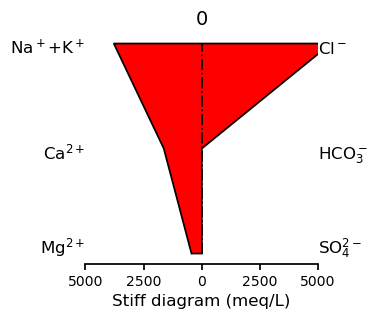

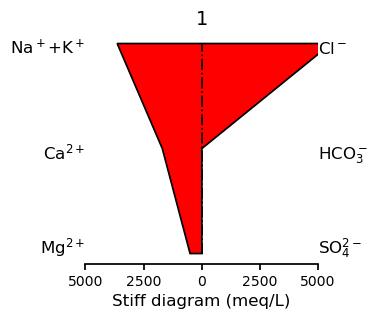

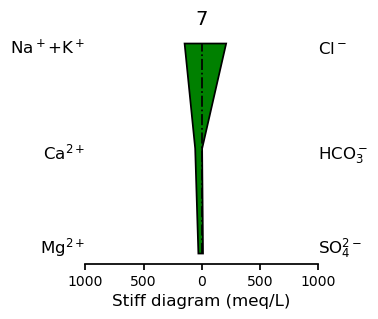

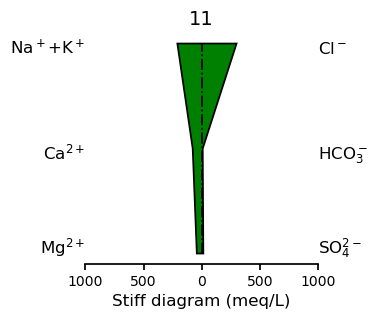

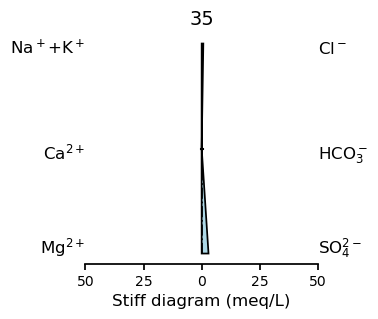

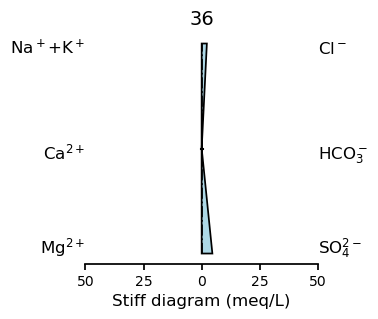

In [59]:
plot(df_stiff, unit='mg/L', figname='Stiff diagram', figformat='png')